## Sequence Models

### Part 1:

In [209]:
# Starting by importing useful libraries
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.metrics import f1_score
import math
import random

In [210]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kavya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [211]:
# Make a seeding function for reproducibility
def seeder(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seeder()

We want to read all the different files in each folder:

In [212]:
def get_file(path):
    data = []
    for file_path in sorted(glob.glob(path)):
        with open(file_path, 'r', encoding='utf-8') as file:
            data.append(file.read())
    return ' '.join(data)

In [213]:
seeder()
train_data = get_file('data_train/*')
val_data = get_file('data_val/*')
test_data = get_file('data_test/*')

Toknenising the raw data:

In [214]:
seeder()
train_tokens = word_tokenize(train_data.lower())
val_tokens = word_tokenize(val_data.lower())
test_tokens = word_tokenize(test_data.lower())

Making the vocabulary and the indices:

In [215]:
seeder()
vocab = {word for word, count in Counter(train_tokens).items() if count >= 100}
word_to_idx = {word: i for i, word in enumerate(vocab)}
word_to_idx['<unk>'] = len(word_to_idx)

idx_to_word = {idx: word for word, idx in word_to_idx.items()}

Making the context-target pairs with unknown token for unknown words:

In [216]:
def make_ct_pairs(tokens, word_to_idx, window_size=2):
    pairs = []
    for i in range(len(tokens)):
        target = tokens[i] if tokens[i] in word_to_idx else '<unk>'

        # The backslash "\" continues the current line operation to the next line
        context_indices = [j for j in range(max(0, i - window_size), i)] + \
                          [j for j in range(i + 1, min(len(tokens), i + 1 + window_size))]
        
        context = [tokens[idx] if tokens[idx] in word_to_idx else '<unk>' for idx in context_indices]
        context_indices = [word_to_idx.get(word, word_to_idx['<unk>']) for word in context]
        target_index = word_to_idx.get(target, word_to_idx['<unk>'])
        pairs.append((context_indices, target_index))
    return pairs

In [217]:
seeder()
train_pairs = make_ct_pairs(train_tokens, word_to_idx)
val_pairs = make_ct_pairs(val_tokens, word_to_idx)
test_pairs = make_ct_pairs(test_tokens, word_to_idx)

In [218]:
train_freq = FreqDist(train_tokens)

In [219]:
print(f'Total number of words in training set: {len(train_tokens)}')
print(f'Number of distinct words in training set: {len(train_freq)}')
print(f'Size of vocabulary (for words appearing over 100 times): {len(vocab)}')

Total number of words in training set: 2755905
Number of distinct words in training set: 53001
Size of vocabulary (for words appearing over 100 times): 2096


Preparing the datasets:

In [220]:
class CBOWDataset(Dataset):
    def __init__(self, pairs, word_to_idx):
        self.pairs = pairs
        self.word_to_idx = word_to_idx

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]

        # Padding to match length
        max_len = 4 
        if len(context) < max_len:
            context += [self.word_to_idx['<unk>']] * (max_len - len(context))
        elif len(context) > max_len:
            context = context[:max_len]

        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)


seeder()
train_dataset = CBOWDataset(train_pairs, word_to_idx)
val_dataset = CBOWDataset(val_pairs, word_to_idx)
test_dataset = CBOWDataset(test_pairs, word_to_idx)

seeder()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

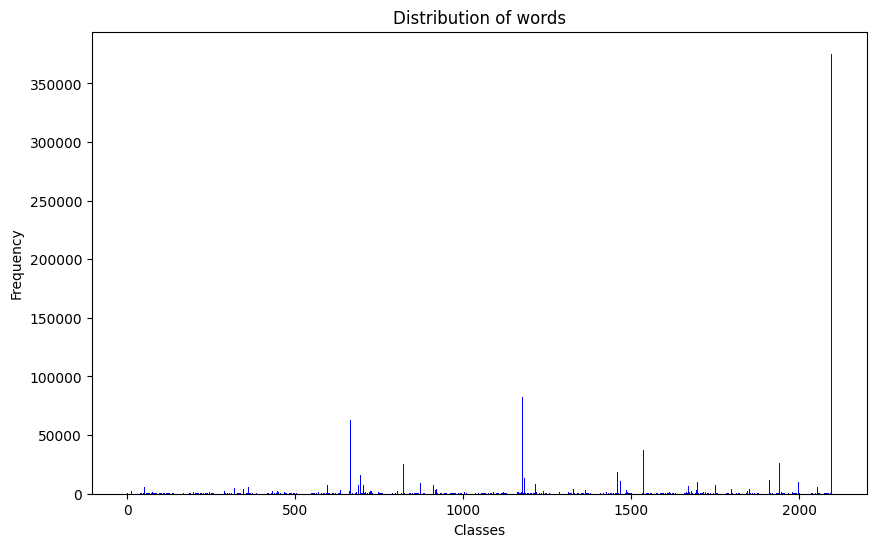

In [221]:
class_counts = Counter()
for _, targets in train_loader:
    class_counts.update(targets.tolist())

classes = list(class_counts.keys())
freqs = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, freqs, color='blue')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Distribution of words')
plt.show()

Designing the CBOW architectures:

In [222]:
class CBOWModel1(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super(CBOWModel1, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.linear = nn.Linear(emb_dim, vocab_size)

    def forward(self, inputs):
        embedded = self.emb(inputs)
        mean_embedded = torch.mean(embedded, dim=1)
        out = self.linear(mean_embedded)

        return out

In [223]:
class CBOWModel2(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim=64):
        super(CBOWModel2, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.linear1 = nn.Linear(emb_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs):
        embedded = self.emb(inputs)
        mean_embedded = torch.mean(embedded, dim=1)
        hidden1 = F.relu(self.linear1(mean_embedded))
        hidden2 = F.relu(self.linear2(hidden1))
        out = self.output(hidden2)
        return out

Training loop:

In [224]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):

    training_losses = []
    validation_losses = []

    # Set to largest value
    best_val_loss = float('inf')

    # For early stopping
    patience_counter = 0
    patience = 2

    device = next(model.parameters()).device

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        # Compute training loss and update
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = loss_fn(outputs, labels)

            # Zero gradients
            optimizer.zero_grad()
            # Backward pass and gradient descent
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        training_losses.append(avg_loss)

        # Compute validation loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)

                # Forward pass
                outputs = model(features)
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)


        print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

            # Save best model state
            best_model = model.state_dict()
            patience_counter = 0 
        else:
            # Increment counter
            patience_counter += 1

        # Early stopping condition
        if patience_counter > patience:
            print(f"Stopping early at epoch {epoch+1} due to increasing validation loss.")
            break

    print('Training complete!')
    
    # Restore best model to the given model
    model.load_state_dict(best_model)
    return training_losses, validation_losses

Getting weights for each class for the loss function:

In [225]:
def get_weights(pairs):
    target_counts = Counter()
    for _, target in pairs:
        target_counts[target] += 1

    total_samples = sum(target_counts.values())

    class_weights = {class_idx: total_samples / count for class_idx, count in target_counts.items()}

    max_index = max(class_weights.keys())
    weights_tensor = torch.zeros(max_index + 1) 
    for idx, weight in class_weights.items():
        weights_tensor[idx] = weight

    weights_tensor = weights_tensor / weights_tensor.max()
    return weights_tensor

weights_tensor = get_weights(train_pairs)

Defining models and training:

In [226]:
vocab_size = len(word_to_idx)
emb_dim = 16

n_epochs = 15

seeder()
model1 = CBOWModel1(vocab_size, emb_dim)
model2 = CBOWModel2(vocab_size, emb_dim)

loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)

opt1 = optim.Adam(model1.parameters(), lr=0.001)
opt2 = optim.Adam(model2.parameters(), lr=0.001)

In [227]:
tl1_1, vl1_1 = train(n_epochs, opt1, model1, loss_fn, train_loader, val_loader)

Epoch 1/15, Training Loss: 7.1110, Validation Loss: 6.8608
Epoch 2/15, Training Loss: 6.6510, Validation Loss: 6.7013
Epoch 3/15, Training Loss: 6.5198, Validation Loss: 6.6549
Epoch 4/15, Training Loss: 6.4563, Validation Loss: 6.6242
Epoch 5/15, Training Loss: 6.4213, Validation Loss: 6.6029
Epoch 6/15, Training Loss: 6.3994, Validation Loss: 6.6060
Epoch 7/15, Training Loss: 6.3845, Validation Loss: 6.5942
Epoch 8/15, Training Loss: 6.3767, Validation Loss: 6.5920
Epoch 9/15, Training Loss: 6.3697, Validation Loss: 6.5951
Epoch 10/15, Training Loss: 6.3632, Validation Loss: 6.6056
Epoch 11/15, Training Loss: 6.3613, Validation Loss: 6.5862
Epoch 12/15, Training Loss: 6.3584, Validation Loss: 6.5825
Epoch 13/15, Training Loss: 6.3578, Validation Loss: 6.5669
Epoch 14/15, Training Loss: 6.3562, Validation Loss: 6.5901
Epoch 15/15, Training Loss: 6.3544, Validation Loss: 6.5905
Training complete!


In [228]:
tl1_2, vl1_2 = train(n_epochs, opt2, model2, loss_fn, train_loader, val_loader)

Epoch 1/15, Training Loss: 7.3853, Validation Loss: 7.2212
Epoch 2/15, Training Loss: 7.0292, Validation Loss: 7.0571
Epoch 3/15, Training Loss: 6.8523, Validation Loss: 6.9672
Epoch 4/15, Training Loss: 6.7535, Validation Loss: 6.9083
Epoch 5/15, Training Loss: 6.6904, Validation Loss: 6.8689
Epoch 6/15, Training Loss: 6.6480, Validation Loss: 6.8619
Epoch 7/15, Training Loss: 6.6206, Validation Loss: 6.8313
Epoch 8/15, Training Loss: 6.6016, Validation Loss: 6.8456
Epoch 9/15, Training Loss: 6.5823, Validation Loss: 6.8255
Epoch 10/15, Training Loss: 6.5680, Validation Loss: 6.8173
Epoch 11/15, Training Loss: 6.5589, Validation Loss: 6.7812
Epoch 12/15, Training Loss: 6.5478, Validation Loss: 6.8028
Epoch 13/15, Training Loss: 6.5391, Validation Loss: 6.8051
Epoch 14/15, Training Loss: 6.5312, Validation Loss: 6.7929
Stopping early at epoch 14 due to increasing validation loss.
Training complete!


Model evaluating function using weighted F1 score:

In [229]:
def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad(): 
        device = next(model.parameters()).device
        for data, targets in data_loader:
            # Get prediction from model
            data = data.to(device)
            targets = targets.to(device)    
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)  
            
            # Compute F1 score
            true_labels.extend(targets.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return f1

In [230]:
models_dict = {
    'Model 1': model1,
    'Model 2': model2
}

models_losses = {
    'Model 1': [tl1_1, vl1_1],
    'Model 2': [tl1_2, vl1_2]
}

In [231]:
val_performances = {}
for name, model in models_dict.items():
    val_f1 = evaluate_model(model, val_loader)
    val_performances[name] = val_f1
    print(f"F1 Performance for {name} on Validation set: {val_f1:.4f}")

F1 Performance for Model 1 on Validation set: 0.0249
F1 Performance for Model 2 on Validation set: 0.0126


In [232]:
best_model_name = max(val_performances, key=val_performances.get)
best_model = models_dict[best_model_name]
print(f"Best Model: {best_model_name} with Validation F1 performance: {val_performances[best_model_name]:.4f}")

Best Model: Model 1 with Validation F1 performance: 0.0249


Displaying training and validation losses of the best model:

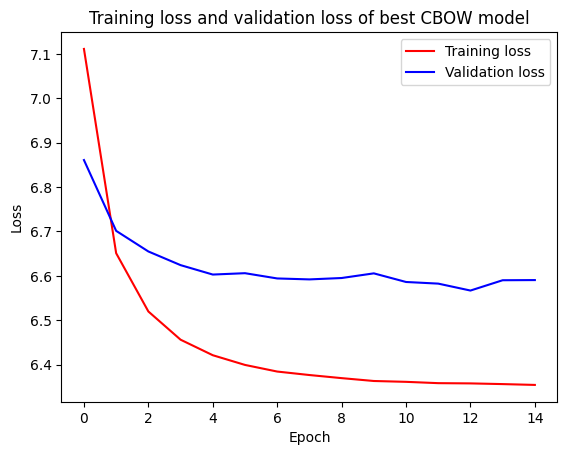

In [233]:
best_tl = (models_losses[best_model_name])[0]
best_vl = (models_losses[best_model_name])[1]

plt.plot(best_tl, label='Training loss', color='r')
plt.plot(best_vl, label='Validation loss', color='b')

plt.title('Training loss and validation loss of best CBOW model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [234]:
test_f1 = evaluate_model(best_model, test_loader)
print(f"F1 Performance for {best_model_name} on Test set: {test_f1:.4f}")

F1 Performance for Model 1 on Test set: 0.0262


Save model and embeddings:

In [235]:
torch.save(best_model.state_dict(), 'best_cbow.pth')

In [236]:
embeddings = model1.emb.weight.data
norm_embeddings = F.normalize(embeddings, p=2, dim=1)
cos_matrix = torch.matmul(norm_embeddings, norm_embeddings.t())

Making the cosine similarity matrix:

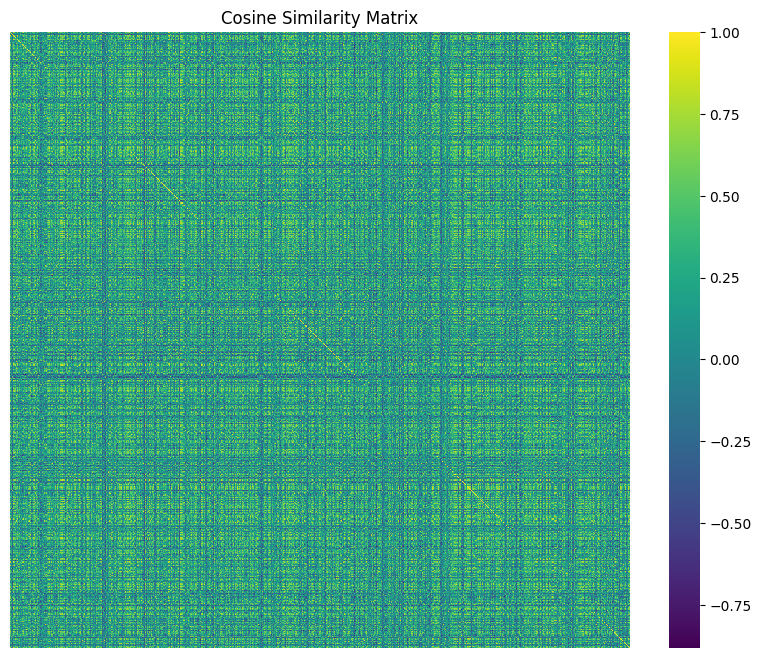

In [237]:
plt.figure(figsize=(10, 8))
sns.heatmap(cos_matrix, xticklabels=False, yticklabels=False, cmap='viridis')
plt.title('Cosine Similarity Matrix')
plt.show()

In [238]:
emb_np = embeddings.numpy()
vocab_ordered = [idx_to_word[i] for i in range(len(idx_to_word))]

vocab_df = pd.DataFrame(vocab_ordered)
emb_df = pd.DataFrame(emb_np)

vocab_df.to_csv('vocabulary.tsv', sep='\t', header=False, index=False)
emb_df.to_csv('embeddings.tsv', sep='\t', header=False, index=False)

### Part 2

In [239]:
max_len = 4

In [240]:
# embeddings_data = pd.read_csv('embeddings.tsv', delimiter='\t', header=None)

# emb_np = embeddings_data.values
# embeddings = torch.tensor(emb_np, dtype=torch.float32)

Defining the different architectures:

In [241]:
class MLPModel(nn.Module):
    def __init__(self, emb_weights, output_size=12, hidden_dim=128):
        super(MLPModel, self).__init__()
        # Get embedding
        self.emb = nn.Embedding.from_pretrained(emb_weights, freeze=True)
        emb_dim = emb_weights.shape[1]
        
        self.fc1 = nn.Linear(emb_dim * max_len, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [242]:
class MHSAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MHSAttention, self).__init__()
        self.heads = heads
        self.head_dim = embed_size // heads
        
        self.Wq = nn.ModuleList([nn.Linear(embed_size, self.head_dim, bias=False) for _ in range(heads)])
        self.Wk = nn.ModuleList([nn.Linear(embed_size, self.head_dim, bias=False) for _ in range(heads)])
        self.Wv = nn.ModuleList([nn.Linear(embed_size, self.head_dim, bias=False) for _ in range(heads)])
        self.Wo = nn.Linear(embed_size, embed_size)

    def forward(self, x):        
        query = [Wq(x) for Wq in self.Wq]
        key = [Wk(x) for Wk in self.Wk]
        value = [Wv(x) for Wv in self.Wv]

        # Compute dot product and concatenate
        heads = [self.scaled_dot_product_attention(q, k, v)[0] for q, k, v in zip(query, key, value)]
        heads_concat = torch.cat(heads, dim=-1)
        
        out = self.Wo(heads_concat)
        return out
    
    def scaled_dot_product_attention(self, query, key, value):
        # Calculating the dot product between queries and keys for each batch and head
        matmul_qk = torch.matmul(query, key.transpose(-1, -2))
        
        d_k = query.size(-1)  
        scaled_attention_logits = matmul_qk / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        
        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        
        output = torch.matmul(attention_weights, value)
        
        return output, attention_weights


class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * -(math.log(10000.0) / emb_dim))
        pos_encoding = torch.zeros(max_len, emb_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        # register_buffer here ensures that we don't update positional encoding during backpropagation
        self.register_buffer('pos_encoding', pos_encoding)

    def forward(self, x):
        return x + self.pos_encoding[:x.size(1), :]


class MLPAttentionModel(nn.Module):
    def __init__(self, emb_weights, output_size=12, hidden_size=128, heads=8):
        super(MLPAttentionModel, self).__init__()
        self.emb = nn.Embedding.from_pretrained(emb_weights, freeze=True)
        emb_dim = emb_weights.shape[1]
        self.attention = MHSAttention(emb_dim, heads)
        self.pos_encoding = PositionalEncoding(emb_dim)
        self.fc1 = nn.Linear(emb_dim * max_len, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.emb(x)
        x = self.pos_encoding(x)
        # Modify dimensions for attention layer
        x = x.permute(1, 0, 2)
        attn_outputs = self.attention(x)
        x = attn_outputs.permute(1, 0, 2)
        # Flatten for FC layer
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [243]:
class RNNModel(nn.Module):
    def __init__(self, emb_weights, output_size=12, hidden_size=256, num_layers=2):
        super(RNNModel, self).__init__()
        self.emb = nn.Embedding.from_pretrained(emb_weights, freeze=True)
        emb_dim = emb_weights.shape[1]
        self.rnn = nn.RNN(emb_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.emb(x)
        _, h_n = self.rnn(x)
        x = h_n[-1]
        x = self.fc(x)
        return x

In [244]:
class RNNModel2(nn.Module):
    def __init__(self, emb_weights, output_size=12, hidden_size=256, num_layers=2):
        super(RNNModel2, self).__init__()
        self.emb = nn.Embedding.from_pretrained(emb_weights, freeze=True)
        emb_dim = emb_weights.shape[1]
        self.rnn = nn.LSTM(emb_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.emb(x)
        _, (h_n, c_n) = self.rnn(x)
        x = h_n[-1]
        x = self.fc(x)
        return x

Defining conjugations:

In [245]:
conjugations = {
    'be': 0, 'am': 1, 'are': 2, 'is': 3, 'was': 4, 'were': 5,
    'been': 6, 'being': 7, 'have': 8, 'has': 9, 'had': 10, 'having': 11
}

Filtering and preparing the new data:

In [246]:
def filter_pairs(pairs):
    filtered_pairs = []
    for context, target in pairs:
        target_word = idx_to_word[target]
        if target_word in conjugations:
            filtered_pairs.append((context, conjugations[target_word]))

    return filtered_pairs

seeder()
train_pairs_filtered = filter_pairs(train_pairs)
val_pairs_filtered = filter_pairs(val_pairs)
test_pairs_filtered = filter_pairs(test_pairs)

# Can reuse the CBOW dataset wrapper class
seeder()
train_dataset2 = CBOWDataset(train_pairs_filtered, word_to_idx)
val_dataset2 = CBOWDataset(val_pairs_filtered, word_to_idx)
test_dataset2 = CBOWDataset(test_pairs_filtered, word_to_idx)

seeder()
train_loader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=64, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False)

In [247]:
seeder()
model2_1 = MLPModel(emb_weights=embeddings)

seeder()
weights_tensor2 = get_weights(train_pairs_filtered)
loss_fn2 = nn.CrossEntropyLoss(weight=weights_tensor2)

opt2_1 = optim.Adam(model2_1.parameters(), lr=0.001)

In [248]:
tl2_1, vl2_1 = train(n_epochs, opt2_1, model2_1, loss_fn2, train_loader2, val_loader2)

Epoch 1/15, Training Loss: 1.3086, Validation Loss: 1.2222
Epoch 2/15, Training Loss: 1.1562, Validation Loss: 1.1630
Epoch 3/15, Training Loss: 1.1062, Validation Loss: 1.1323
Epoch 4/15, Training Loss: 1.0790, Validation Loss: 1.1324
Epoch 5/15, Training Loss: 1.0580, Validation Loss: 1.1118
Epoch 6/15, Training Loss: 1.0415, Validation Loss: 1.0898
Epoch 7/15, Training Loss: 1.0289, Validation Loss: 1.0976
Epoch 8/15, Training Loss: 1.0192, Validation Loss: 1.1081
Epoch 9/15, Training Loss: 1.0081, Validation Loss: 1.1322
Stopping early at epoch 9 due to increasing validation loss.
Training complete!


In [249]:
seeder()
model2_2 = MLPAttentionModel(emb_weights=embeddings)

opt2_2 = optim.Adam(model2_2.parameters(), lr=0.001)

In [250]:
tl2_2, vl2_2 = train(n_epochs, opt2_2, model2_2, loss_fn2, train_loader2, val_loader2)

Epoch 1/15, Training Loss: 1.4071, Validation Loss: 1.2343
Epoch 2/15, Training Loss: 1.2051, Validation Loss: 1.1852
Epoch 3/15, Training Loss: 1.1592, Validation Loss: 1.1526
Epoch 4/15, Training Loss: 1.1278, Validation Loss: 1.1561
Epoch 5/15, Training Loss: 1.1067, Validation Loss: 1.1290
Epoch 6/15, Training Loss: 1.0916, Validation Loss: 1.1420
Epoch 7/15, Training Loss: 1.0781, Validation Loss: 1.1361
Epoch 8/15, Training Loss: 1.0695, Validation Loss: 1.1313
Stopping early at epoch 8 due to increasing validation loss.
Training complete!


In [251]:
seeder()
model2_3 = MLPAttentionModel(emb_weights=embeddings, hidden_size=256, heads=16)

opt2_3 = optim.Adam(model2_3.parameters(), lr=0.001)

In [252]:
tl2_3, vl2_3 = train(n_epochs, opt2_3, model2_3, loss_fn2, train_loader2, val_loader2)

Epoch 1/15, Training Loss: 1.3504, Validation Loss: 1.1872
Epoch 2/15, Training Loss: 1.1521, Validation Loss: 1.1437
Epoch 3/15, Training Loss: 1.0993, Validation Loss: 1.1226
Epoch 4/15, Training Loss: 1.0695, Validation Loss: 1.0985
Epoch 5/15, Training Loss: 1.0449, Validation Loss: 1.0839
Epoch 6/15, Training Loss: 1.0223, Validation Loss: 1.0888
Epoch 7/15, Training Loss: 1.0044, Validation Loss: 1.0718
Epoch 8/15, Training Loss: 0.9889, Validation Loss: 1.1043
Epoch 9/15, Training Loss: 0.9735, Validation Loss: 1.0819
Epoch 10/15, Training Loss: 0.9600, Validation Loss: 1.0537
Epoch 11/15, Training Loss: 0.9481, Validation Loss: 1.0881
Epoch 12/15, Training Loss: 0.9348, Validation Loss: 1.1104
Epoch 13/15, Training Loss: 0.9288, Validation Loss: 1.0970
Stopping early at epoch 13 due to increasing validation loss.
Training complete!


In [253]:
seeder()
model2_4 = RNNModel(emb_weights=embeddings)

opt2_4 = optim.Adam(model2_4.parameters(), lr=0.001)

In [254]:
tl2_4, vl2_4 = train(n_epochs, opt2_4, model2_4, loss_fn2, train_loader2, val_loader2)

Epoch 1/15, Training Loss: 1.2977, Validation Loss: 1.2334
Epoch 2/15, Training Loss: 1.1465, Validation Loss: 1.1807
Epoch 3/15, Training Loss: 1.0825, Validation Loss: 1.1248
Epoch 4/15, Training Loss: 1.0354, Validation Loss: 1.1276
Epoch 5/15, Training Loss: 1.0005, Validation Loss: 1.1466
Epoch 6/15, Training Loss: 0.9690, Validation Loss: 1.1225
Epoch 7/15, Training Loss: 0.9437, Validation Loss: 1.1137
Epoch 8/15, Training Loss: 0.9134, Validation Loss: 1.1543
Epoch 9/15, Training Loss: 0.8945, Validation Loss: 1.1590
Epoch 10/15, Training Loss: 0.8791, Validation Loss: 1.1379
Stopping early at epoch 10 due to increasing validation loss.
Training complete!


In [255]:
seeder()
model2_5 = RNNModel2(emb_weights=embeddings)

opt2_5 = optim.Adam(model2_5.parameters(), lr=0.001)

In [256]:
tl2_5, vl2_5 = train(n_epochs, opt2_5, model2_5, loss_fn2, train_loader2, val_loader2)

Epoch 1/15, Training Loss: 1.2144, Validation Loss: 1.0836
Epoch 2/15, Training Loss: 1.0179, Validation Loss: 1.0451
Epoch 3/15, Training Loss: 0.9280, Validation Loss: 1.0133
Epoch 4/15, Training Loss: 0.8433, Validation Loss: 1.0497
Epoch 5/15, Training Loss: 0.7632, Validation Loss: 1.1091
Epoch 6/15, Training Loss: 0.6880, Validation Loss: 1.1089
Stopping early at epoch 6 due to increasing validation loss.
Training complete!


In [257]:
models_dict2 = {
    'Model 1': model2_1,
    'Model 2': model2_2,
    'Model 3': model2_3,
    'Model 4': model2_4,
    'Model 5': model2_5
}

models_losses2 = {
    'Model 1': [tl2_1, vl2_1],
    'Model 2': [tl2_2, vl2_2],
    'Model 3': [tl2_3, vl2_3],
    'Model 4': [tl2_4, vl2_4],
    'Model 5': [tl2_5, vl2_5]
}

In [258]:
val_performances2 = {}
for name, model in models_dict2.items():
    val_f1 = evaluate_model(model, val_loader2)
    val_performances2[name] = val_f1
    print(f"F1 Performance for {name} on Validation set: {val_f1:.4f}")

F1 Performance for Model 1 on Validation set: 0.4753
F1 Performance for Model 2 on Validation set: 0.4664
F1 Performance for Model 3 on Validation set: 0.5086
F1 Performance for Model 4 on Validation set: 0.5253
F1 Performance for Model 5 on Validation set: 0.5611


In [259]:
best_model_name2 = max(val_performances2, key=val_performances2.get)
best_model2 = models_dict2[best_model_name2]
print(f"Best Model: {best_model_name2} with Validation F1 performance: {val_performances2[best_model_name2]:.4f}")

Best Model: Model 5 with Validation F1 performance: 0.5611


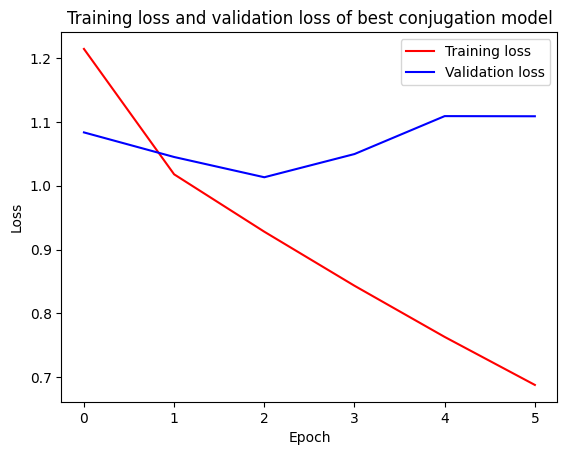

In [260]:
best_tl2 = (models_losses2[best_model_name2])[0]
best_vl2 = (models_losses2[best_model_name2])[1]

plt.plot(best_tl2, label='Training loss', color='r')
plt.plot(best_vl2, label='Validation loss', color='b')

plt.title('Training loss and validation loss of best conjugation model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [261]:
test_f1 = evaluate_model(best_model2, test_loader2)
print(f"F1 Performance for {best_model_name2} on Test set: {test_f1:.4f}")

F1 Performance for Model 5 on Test set: 0.5100


In [262]:
torch.save(best_model2.state_dict(), 'best_conj_model.pth')

### Part 3

New function and dataset wrapper class for context before target:

In [263]:
def make_ct_pairs2(tokens, word_to_idx, context_size=4):
    pairs = []
    for i in range(len(tokens) - context_size):
        context = tokens[i:i + context_size]
        target = tokens[i + context_size]

        context_indices = [word_to_idx.get(word, word_to_idx['<unk>']) for word in context]
        target_index = word_to_idx.get(target, word_to_idx['<unk>'])

        pairs.append((context_indices, target_index))
    return pairs

class NextWordPredDataset(Dataset):
    def __init__(self, pairs, word_to_idx):
        self.pairs = pairs
        self.word_to_idx = word_to_idx

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)


In [264]:
seeder()
train_pairs_next = make_ct_pairs2(train_tokens, word_to_idx)
val_pairs_next = make_ct_pairs2(val_tokens, word_to_idx)
test_pairs_next = make_ct_pairs2(test_tokens, word_to_idx)

seeder()
train_dataset3 = NextWordPredDataset(train_pairs_next, word_to_idx)
val_dataset3 = NextWordPredDataset(val_pairs_next, word_to_idx)
test_dataset3 = NextWordPredDataset(test_pairs_next, word_to_idx)

seeder()
train_loader3 = DataLoader(train_dataset3, batch_size=64, shuffle=True)
val_loader3 = DataLoader(val_dataset3, batch_size=64, shuffle=False)
test_loader3 = DataLoader(test_dataset3, batch_size=64, shuffle=False)

Define the RNN architectures:

In [265]:
class RNNModel3(nn.Module):
    def __init__(self, embeddings, hidden_size=64, num_layers=2):
        super(RNNModel3, self).__init__()
        self.emb_dim = embeddings.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = embeddings.shape[0]
        
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=True)
        
        self.rnn = nn.GRU(self.emb_dim, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, self.vocab_size)

    def forward(self, x):
        x = self.emb(x)
        _, h_n = self.rnn(x)
        x = h_n[-1]
        x = self.fc(x)
        return x

In [266]:
class RNNModel4(nn.Module):
    def __init__(self, embeddings, hidden_size=64, num_layers=2):
        super(RNNModel4, self).__init__()
        self.emb_dim = embeddings.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = embeddings.shape[0]
        
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=True)
        
        self.rnn = nn.LSTM(self.emb_dim, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, self.vocab_size)

    def forward(self, x):
        x = self.emb(x)
        _, (h_n, c_n) = self.rnn(x)
        x = h_n[-1]
        x = self.fc(x)
        return x

In [267]:
seeder()
model3_1 = RNNModel3(embeddings)

loss_fn3 = nn.CrossEntropyLoss(weight=get_weights(train_pairs_next))

opt3_1 = optim.Adam(model3_1.parameters(), lr=0.001)

In [268]:
tl3_1, vl3_1 = train(n_epochs, opt3_1, model3_1, loss_fn3, train_loader3, val_loader3)

Epoch 1/15, Training Loss: 6.4012, Validation Loss: 6.3277
Epoch 2/15, Training Loss: 6.1048, Validation Loss: 6.2441
Epoch 3/15, Training Loss: 6.0345, Validation Loss: 6.2893
Epoch 4/15, Training Loss: 5.9972, Validation Loss: 6.2591
Epoch 5/15, Training Loss: 5.9756, Validation Loss: 6.2796
Stopping early at epoch 5 due to increasing validation loss.
Training complete!


In [269]:
seeder()
model3_2 = RNNModel4(embeddings)

opt3_2 = optim.Adam(model3_2.parameters(), lr=0.001)

In [270]:
tl3_2, vl3_2 = train(n_epochs, opt3_2, model3_2, loss_fn3, train_loader3, val_loader3)

Epoch 1/15, Training Loss: 6.4244, Validation Loss: 6.2993
Epoch 2/15, Training Loss: 6.0792, Validation Loss: 6.2467
Epoch 3/15, Training Loss: 5.9932, Validation Loss: 6.2130
Epoch 4/15, Training Loss: 5.9411, Validation Loss: 6.2059
Epoch 5/15, Training Loss: 5.9103, Validation Loss: 6.2096
Epoch 6/15, Training Loss: 5.8877, Validation Loss: 6.2223
Epoch 7/15, Training Loss: 5.8734, Validation Loss: 6.1989
Epoch 8/15, Training Loss: 5.8610, Validation Loss: 6.2232
Epoch 9/15, Training Loss: 5.8511, Validation Loss: 6.2114
Epoch 10/15, Training Loss: 5.8439, Validation Loss: 6.2079
Stopping early at epoch 10 due to increasing validation loss.
Training complete!


In [271]:
seeder()
model3_3 = RNNModel4(embeddings=embeddings, hidden_size=128, num_layers=4)

opt3_3 = optim.Adam(model3_2.parameters(), lr=0.001)

In [272]:
tl3_3, vl3_3 = train(n_epochs, opt3_3, model3_3, loss_fn3, train_loader3, val_loader3)

Epoch 1/15, Training Loss: 7.6499, Validation Loss: 7.6490
Epoch 2/15, Training Loss: 7.6498, Validation Loss: 7.6490
Epoch 3/15, Training Loss: 7.6499, Validation Loss: 7.6490
Epoch 4/15, Training Loss: 7.6499, Validation Loss: 7.6490
Stopping early at epoch 4 due to increasing validation loss.
Training complete!


In [273]:
models_dict3 = {
    'Model 1': model3_1,
    'Model 2': model3_2,
    'Model 3': model3_3
}

models_losses3 = {
    'Model 1': [tl3_1, vl3_1],
    'Model 2': [tl3_2, vl3_2],
    'Model 3': [tl3_3, vl3_3]
}

In [274]:
val_performances3 = {}
for name, model in models_dict3.items():
    val_f1 = evaluate_model(model, val_loader3)
    val_performances3[name] = val_f1
    print(f"F1 Performance for {name} on Validation set: {val_f1:.4f}")

F1 Performance for Model 1 on Validation set: 0.0250
F1 Performance for Model 2 on Validation set: 0.0282
F1 Performance for Model 3 on Validation set: 0.0000


In [275]:
best_model_name3= max(val_performances3, key=val_performances3.get)
best_model3 = models_dict3[best_model_name3]
print(f"Best Model: {best_model_name3} with Validation F1 performance: {val_performances3[best_model_name3]:.4f}")

Best Model: Model 2 with Validation F1 performance: 0.0282


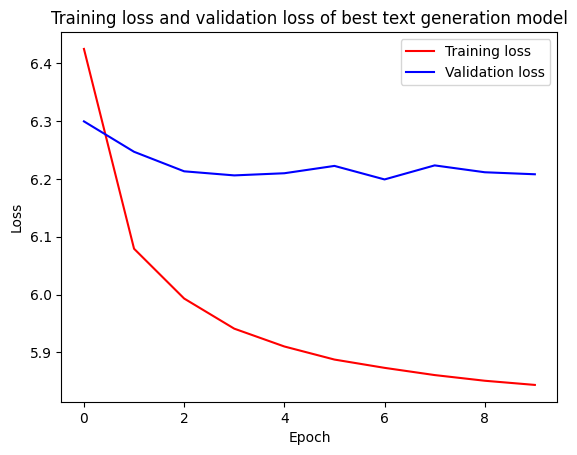

In [276]:
best_tl3 = (models_losses3[best_model_name3])[0]
best_vl3 = (models_losses3[best_model_name3])[1]

plt.plot(best_tl3, label='Training loss', color='r')
plt.plot(best_vl3, label='Validation loss', color='b')

plt.title('Training loss and validation loss of best text generation model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [277]:
test_f1 = evaluate_model(best_model3, test_loader3)
print(f"F1 Performance for {best_model_name3} on Test set: {test_f1:.4f}")

F1 Performance for Model 2 on Test set: 0.0254


In [278]:
torch.save(best_model3.state_dict(), 'best_beam_model.pth')

In [279]:
# best_model3 = RNNModel3(embeddings)

# state_dict = torch.load('best_beam_model.pth')
# best_model3.load_state_dict(state_dict)

Implementation of beam search:

In [280]:
def beam_search(model, initial_sentence, beam_width=3, num_words=5):
    initial_idx = [word_to_idx[word] for word in initial_sentence.split()]

    # Set tensor dimension
    initial_tensor = torch.tensor(initial_idx, dtype=torch.long).unsqueeze(0)

    # Shape: (sequence tensor, log probability)
    candidates = [(initial_tensor, 0.0)]

    # Set model to evaluation mode
    model.eval()

    for _ in range(num_words):
        all_candidates = []

        # Prepare batch for processing
        current_seqs = torch.cat([cand[0] for cand in candidates], dim=0) 

        with torch.no_grad():
            # Get output and log probability
            logits = model(current_seqs)
            log_probs = F.log_softmax(logits, dim=-1)

        # Get top k words for each sequence in batch
        topk_probs, topk_idx = torch.topk(log_probs, beam_width, dim=-1)

        # Create new sequences with the top k words added
        for i in range(len(candidates)):
            seq, score = candidates[i]
            for j in range(beam_width):
                next_word_idx = topk_idx[i, j]
                next_word_prob = topk_probs[i, j]
                new_seq = torch.cat([seq, next_word_idx.unsqueeze(0).unsqueeze(0)], dim=1)
                new_score = score + next_word_prob.item()
                all_candidates.append((new_seq, new_score))

        # Sort all candidates by score in descending order and narrow down to beam width
        candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

    # Choose the sequence with the highest score
    best_sequence, best_score = candidates[0]
    best_sequence = best_sequence.squeeze(0).tolist()
    final_sentence = ' '.join(idx_to_word[idx] for idx in best_sequence)
    return final_sentence

Testing a few sentences:

In [281]:
start_sequence = "he did"
completed_sentence = beam_search(best_model3, start_sequence, beam_width=3, num_words=4)
print(completed_sentence)

he did not recognize anything else


In [282]:
start_sequence2 = "the french"
completed_sentence2 = beam_search(best_model3, start_sequence2, beam_width=3, num_words=4)
print(completed_sentence2)

the french guards galloped toward balashëv


In [310]:
start_sequence3 = "norway"
completed_sentence3 = beam_search(best_model3, start_sequence3, beam_width=3, num_words=4)
print(completed_sentence3)

norway sailed south eastward eastward
